In [1]:
import gymnasium as gym
from gymnasium import spaces
import torch, random
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Net(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_observations, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, n_actions)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [3]:
class MyWorldEnv(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}

    def __init__(self, render_mode = None, size = 5, environment_state = 0) -> None:
        self.render_mode = render_mode
        self.environment_state = environment_state
        self.size = size

        self.max_steps = (self.size**2)*4
        self.agent_location = [0,0]
        self.reward_location = [5,5]
        self.n_reward_location = [[5,1], [4,1], [3,0], [2,1], [1,2], [2,3], [4,4],[4,5]]
        self.observation_spaces = spaces.Discrete(36)
        self.observation_space = spaces.Box(low=0, high=size-1, shape=(2,), dtype=np.float32)
        self.action_space = spaces.Discrete(4)

        self.image_index = 0
        self.agent_state = 0
        self.train = True

    def reset(self, seed=None):
        super().reset(seed=seed)
        self.agent_location = [0,0]
        self.reward_location = [5,5]
        # self.p_reward_location = [[0,4]]
        self.n_reward_location = [[5,1], [4,1], [3,0], [2,1], [1,2], [2,3], [4,4],[4,5]]#[[5,1], [4,1], [3,0], [2,1], [1,2], [2,3], [4,4], [4,5]]
        self.max_steps = 100#(self.size*self.size) * 4
        observation = tuple(self.agent_location)
        return observation, {}

    def render(self, save):
        plt.clf()
        plt.title(" Super Mario World ")
        ax = plt.subplot()
        im = ax.imshow(plt.imread("./images/world.png"), extent=[0, 6, 0, 6])
        for i in range(self.size + 1):
            plt.plot([i, i], [0, self.size], "k")
            plt.plot([0, self.size], [i, i] , "k")

        x,y = self.reward_location
        x = self.size - x - 1
        # plt.fill_betweenx([x, x+1], y, y+1, color="red")
        agent = AnnotationBbox(OffsetImage(plt.imread('./images/PrincessPeach.webp'), zoom=0.18),np.add([y,x], [0.7, 0.5]), frameon=False)
        ax.add_artist(agent)

        for nReward in self.n_reward_location:
            x,y = nReward
            x = self.size - x - 1
            # plt.fill_betweenx([x, x +1], y, y+1, color="black")
            agent = AnnotationBbox(OffsetImage(plt.imread('./images/spiny.webp'), zoom=0.08),np.add([y,x], [0.5, 0.5]), frameon=False)
            ax.add_artist(agent)

        # for pReward in self.p_reward_location:
        #     x,y = pReward
        #     x = self.size - x - 1
        #     plt.fill_betweenx([x, x +1], y, y+1, color="green")
        #     agent = AnnotationBbox(OffsetImage(plt.imread('./images/spiny.webp'), zoom=0.08),np.add([y,x], [0.5, 0.5]), frameon=False)
        #     ax.add_artist(agent)

        x,y = self.agent_location
        x = self.size - x - 1
        # plt.fill_betweenx([x, x + 1], y, y+1, color="blue")
        if self.agent_state == 0:
            agent = AnnotationBbox(OffsetImage(plt.imread('./images/mario.png'), zoom=0.2), np.add([y,x], [0.5, 0.5]), frameon=False)

        if self.agent_state == 1:
            agent = AnnotationBbox(OffsetImage(plt.imread('./images/sad_mario.png'), zoom=0.2), np.add([y,x], [0.5, 0.5]), frameon=False)

        if self.agent_state == 2:
            agent = AnnotationBbox(OffsetImage(plt.imread('./images/happy_mario.png'), zoom=0.06), np.add([5,0], [0.3, 0.5]), frameon=False)
        ax.add_artist(agent)

        #
        plt.xlim(0, self.size)
        plt.ylim(0, self.size)
        plt.xticks([])
        plt.yticks([])
        plt.pause(0.1)
        #plt.show()
        if save:
            plt.savefig("./D"+str(self.image_index+1))

    def step(self, action):
        if self.environment_state :
            p = [0.01, 0.01, 0.01, 0.01] # transition probability
            p[action] += 0.96
            action = np.random.choice(self.action_space.n, p=p)

        if action == 0 : #right
            self.agent_location[1] += 1

        if action == 1 : #left
            self.agent_location[1] -= 1

        if action == 2 : #down
            self.agent_location[0] += 1

        if action == 3 : #up
            self.agent_location[0] -= 1

        isOutside = (self.agent_location[0] < 0 or self.agent_location[0] > 5 or self.agent_location[1] < 0 or self.agent_location[1] > 5)
        self.agent_location = np.clip(self.agent_location, 0, self.size-1)
        reward = 0.005
        if isOutside:
            reward = -1
        self.agent_state = 0
        isTerminate = False
        if np.array_equal(self.agent_location, self.reward_location):
            self.agent_state = 2
            reward = 10
            isTerminate = True

        # if len(self.p_reward_location) and np.any(np.all(self.agent_location == self.p_reward_location, axis=1)):
        #     i = np.where(np.all(self.agent_location == self.p_reward_location, axis=1))[0][0]
        #     self.p_reward_location.pop(i)
        #     print(self.p_reward_location)
        #     reward = 1

        if np.any(np.all(self.agent_location == self.n_reward_location, axis=1)):
            reward = -1
            # isTerminate = True

        self.max_steps -= 1
        if (not self.max_steps) or (isTerminate):
            terminated = True
            truncated = True
        else:
            terminated = False
            truncated = False

        observation = tuple(self.agent_location)
        info = {}

        return observation, reward, terminated, truncated, info

    def setEnvMode(self, type) :
        self.environment_state = type

## DQN Agent - 

In [34]:
class DQN():
    def __init__(self, n_observations, n_actions, enable_per):
        self.policy_net = Net(n_observations, n_actions)
        self.target_net = Net(n_observations, n_actions)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.enable_per = enable_per
        if enable_per:
            self.p_replay_memory = PrioritizedReplayBuffer(10000)
        else:
            self.replay_memory = deque([], maxlen=10000)
        
        self.BATCH_SIZE = 64
        self.env_name = ""
        self.GAMMA = 0.99
        self.TAU = 0.005
        self.LR = 1e-3
        self.E_DECAY = 0.009
        self.epsilon = 0
        self.update_freq = 5
        self.optimizer = optim.AdamW(self.policy_net.parameters(), lr=self.LR, amsgrad=True)
        
        self.rewards = []
        self.epsilon_values = []
        self.eval_rewards = []
        
    def learn(self):

        if self.enable_per and len(self.p_replay_memory) < self.BATCH_SIZE:
            return
        elif not self.enable_per and len(self.replay_memory) < self.BATCH_SIZE:
            return
        
        if self.enable_per:
            batch, indices, weights = self.p_replay_memory.sample(self.BATCH_SIZE)
        else:
            batch = random.sample(self.replay_memory, self.BATCH_SIZE)
            state_batch, action_batch, next_state_batch, reward_batch = zip(*[(item[0], item[1], item[2], item[3]) for item in batch])
        
        
        state_batch, action_batch, next_state_batch, reward_batch = zip(*batch)
        state_batch = torch.cat(state_batch)
        action_batch = torch.cat(action_batch)
        reward_batch = torch.cat(reward_batch)
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)
        
        ##################################
        non_terminate_state_position = torch.tensor([s is not None for s in next_state_batch])
        non_terminate_state = torch.cat([s for s in next_state_batch if s is not None])
        next_state_values = torch.zeros(self.BATCH_SIZE)
        next_state_values[non_terminate_state_position] = self.target_net(non_terminate_state).max(1).values
        ####################################
        # target_state_action_values = torch.cat([self.target_net(ns).max(1).values if ns != None else torch.zeros(1) for ns in next_state_batch])
        
        expected_state_action_values = (next_state_values * self.GAMMA) + reward_batch
        if self.enable_per:
            errors = torch.abs(state_action_values - expected_state_action_values.unsqueeze(1)).detach().cpu().numpy()
            self.p_replay_memory.update_priorities(indices, errors)

        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
        self.optimizer.step()

    def plot(self):
        plt.plot(self.rewards)
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.title('Total Reward Per Episode')
        plt.grid(True)
        plt.show()

    def plotEpsilonVsEpisode(self):
        plt.figure(figsize=(8, 6))
        plt.plot(self.epsilon_values)
        plt.xlabel('Episode')
        plt.ylabel('Epsilon Values')
        plt.title('Epsilon Decay')
        plt.grid(True)
        plt.show()

    def plotTestRewardVsEpisode(self, avg):
        plt.figure(figsize=(8, 6))
        plt.plot(self.eval_rewards)
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.title('Total Reward Per Episode (Greedy Run) --> Average reward - '+avg)
        plt.grid(True)
        plt.show()
    
    def rewardSystem(self, observation, reward):
        if self.env_name == "MountainCar-v0":
            if observation[0] >= 0.4 and observation[0] < 0.5:
                    reward += 1
            if observation[0] >= 0.5:
                    reward += 10
            if reward < 0:
                reward = 0
        
        return observation, reward
        
        
    def train(self, n_episodes):
        total_reward = 0
        for e in range(n_episodes):
            # print("-----------------------------------> n_episode : "+str(e)+" , "+str(self.epsilon)+" , "+str(total_reward))
            state, info = env.reset()
            state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            total_reward = 0
            self.update_freq -= 1
            while True:
                s = np.random.uniform(0.1,1)
                if s < self.epsilon:
                    action = torch.tensor([[env.action_space.sample()]], dtype=torch.long)
                else:
                    action = self.policy_net(state).max(1).indices.view(1, 1)
                observation, reward, terminated, truncated, _ = env.step(action.item())
                observation, reward = self.rewardSystem(observation, reward)
                done = terminated or truncated
                total_reward += reward
                reward = torch.tensor([reward])
                if terminated:
                    next_state = None
                else:
                    next_state = torch.tensor(observation, dtype=torch.float32).unsqueeze(0)
                if not self.enable_per:
                    self.replay_memory.append([state, action, next_state, reward])
                else:
                    max_priority = self.p_replay_memory.max_priority
                    self.p_replay_memory.add(max_priority, (state, action, next_state, reward))

                self.learn()
                state = next_state
                
                target_net_state_dict = self.target_net.state_dict()
                policy_net_state_dict = self.policy_net.state_dict()
                for key in policy_net_state_dict:
                    target_net_state_dict[key] = policy_net_state_dict[key]*self.TAU + target_net_state_dict[key]*(1-self.TAU)
                self.target_net.load_state_dict(target_net_state_dict)
            
                # if not self.update_freq:
                #     print("update")
                #     self.target_net.load_state_dict(self.policy_net.state_dict())
                #     self.update_freq = 10
                
                if terminated or truncated:
                    break
                
            self.epsilon = np.exp(-1*self.E_DECAY*e)
            self.rewards.append(total_reward)
            self.epsilon_values.append(self.epsilon)
            
    def test(self):
        total_reward = 0
        sum_reward = 0
        torch.save(self.policy_net, 'GridEnvironment_Trained_Model_per.pickle')
        for i in range(100):
            state, info = env.reset()
            total_reward = 0
            while True:
                state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
                action = self.policy_net(state).max(1).indices.view(1, 1)
                observation, reward, terminated, truncated, _ = env.step(action.item())
                total_reward += reward
                sum_reward += reward
                # env.render()
                state = observation
                if terminated or truncated:
                    break
            self.eval_rewards.append(total_reward)
        avg = str(round(sum_reward/100, 2))
        self.plotTestRewardVsEpisode(avg)
        print("Average Reward For 100 Episodes (Evaluation) - "+avg)

# Implementing DQN for three environments - 
## 1. **GridWorld**

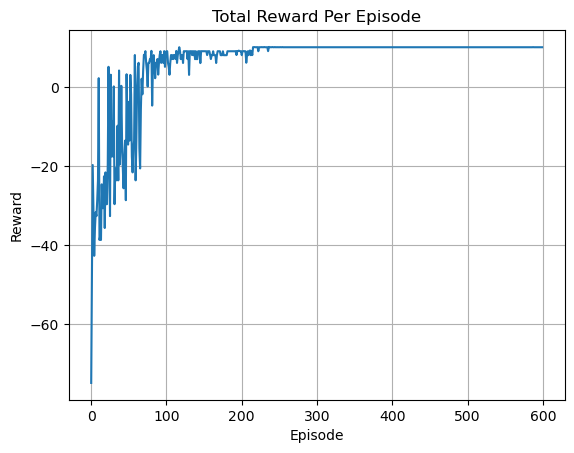

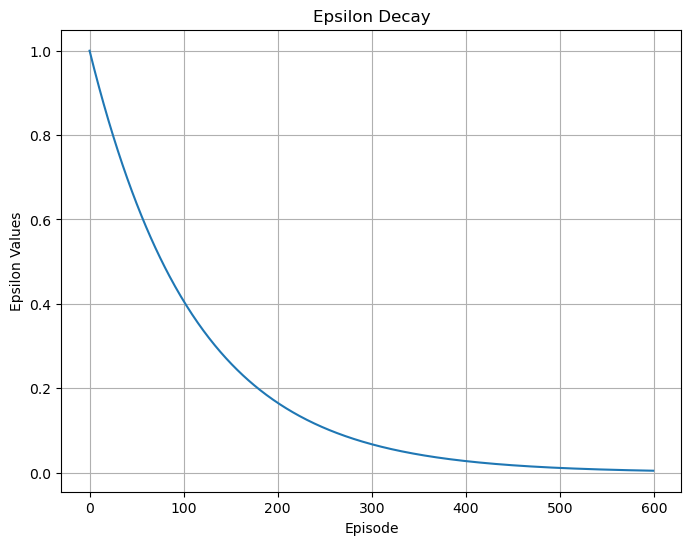

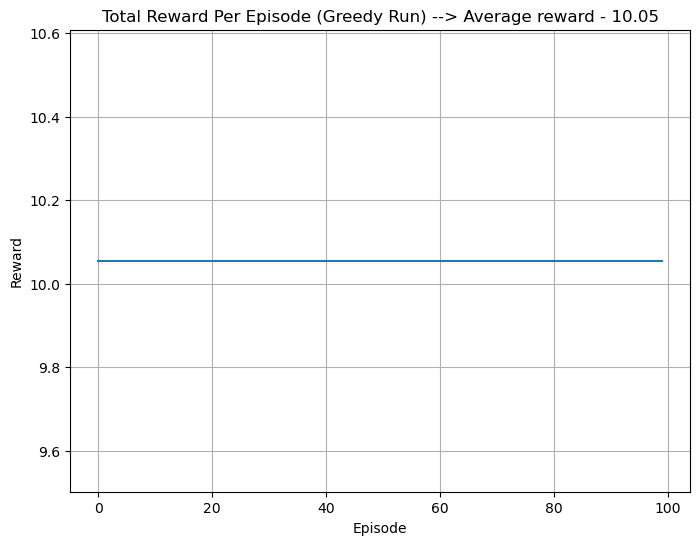

Average Reward For 100 Episodes (Evaluation) - 10.05


In [5]:
if __name__ == "__main__":
#=============================================================== Add your Assignment1 Env
    env = MyWorldEnv("human", 6)
    n_actions = env.action_space.n
    state, info = env.reset()
    n_observations = len(state)
    dqn = DQN(n_observations, n_actions, False)
    dqn.train(600)
    grid_dqn_reward = dqn.rewards
    dqn.plot()
    dqn.plotEpsilonVsEpisode()
    dqn.test()

## 2. **Cartpole**

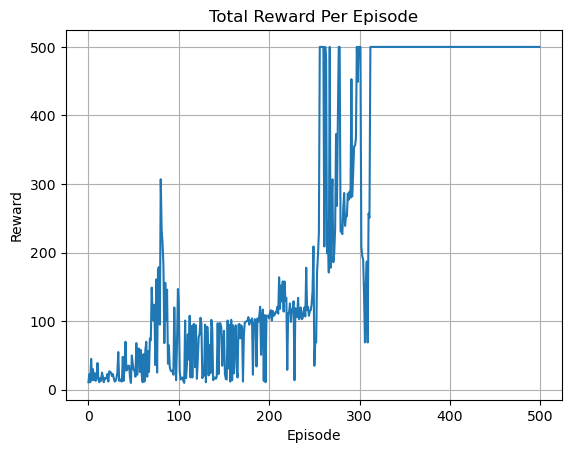

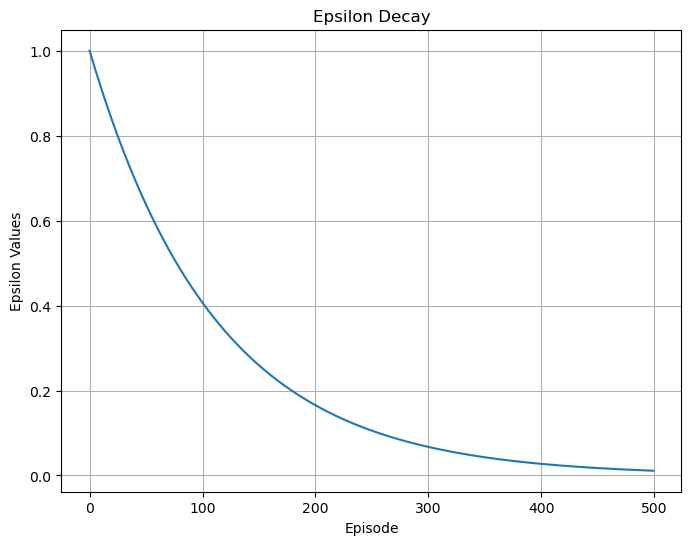

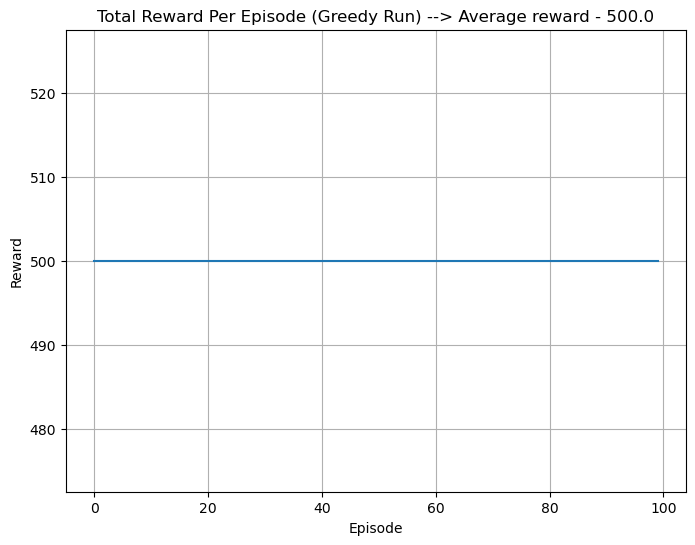

Average Reward For 100 Episodes (Evaluation) - 500.0


In [6]:
#=============================================================== Cartpole
env = gym.make("CartPole-v1")
n_actions = env.action_space.n
state, info = env.reset()
n_observations = len(state)
dqn = DQN(n_observations, n_actions, False)
dqn.train(500)
cartpole_dqn_reward = dqn.rewards
dqn.plot()
dqn.plotEpsilonVsEpisode()
dqn.test()

## 3. **MountainCar**

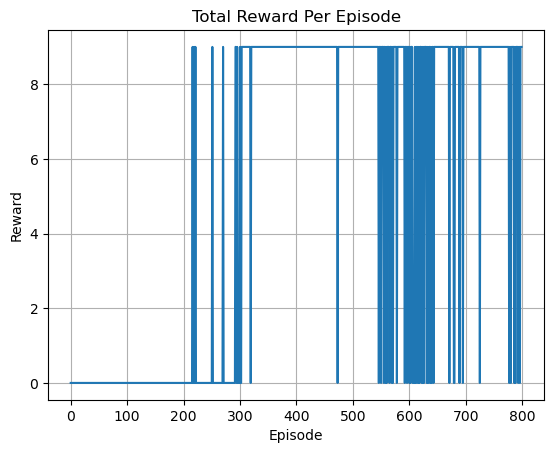

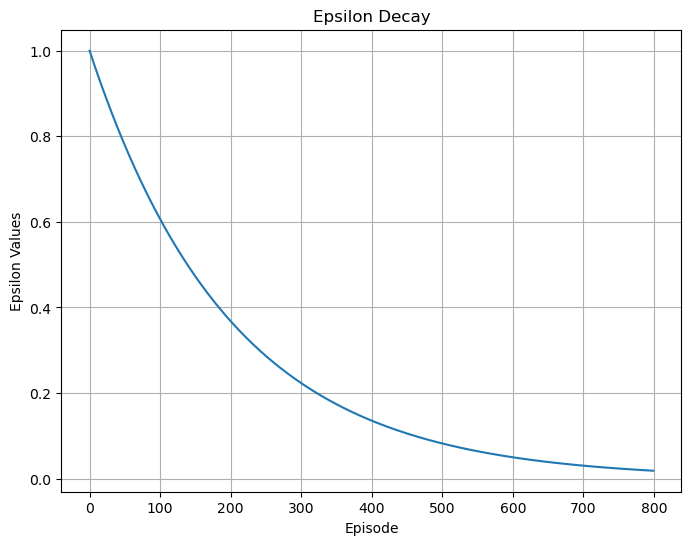

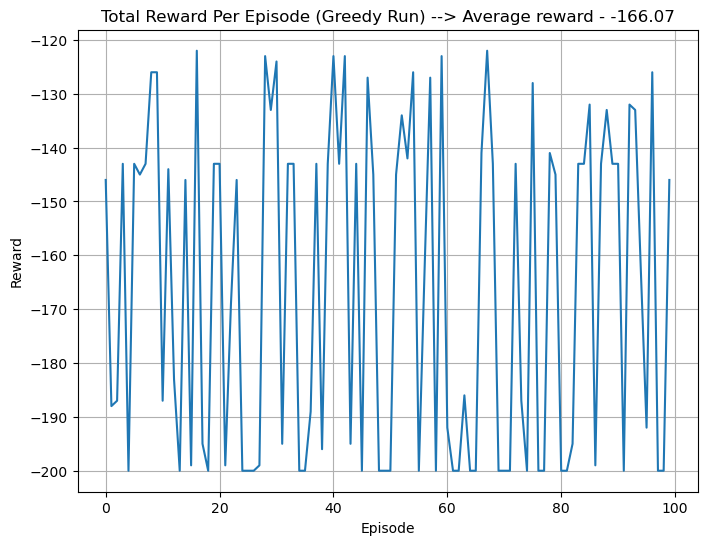

Average Reward For 100 Episodes (Evaluation) - -166.07


In [15]:
#=============================================================== MountainCar
env = gym.make("MountainCar-v0")
n_actions = env.action_space.n
state, info = env.reset()
n_observations = len(state)
dqn = DQN(n_observations, n_actions, False)
dqn.env_name = "MountainCar-v0"
dqn.E_DECAY = 0.005
dqn.train(800)
car_dqn_reward = dqn.rewards
dqn.plot()
dqn.plotEpsilonVsEpisode()
dqn.test()

# Improving vanilla DQN using Prioritized Experience Replay (PER)

In [16]:
class SumTree:
    def __init__(self, size):
        self.size = size 
        self.priority_tree = np.zeros(2 * size - 1)
        self.data = np.zeros(size, dtype=object)
        self.data_pointer = 0

    def add(self, priority, data):
        tree_index = self.data_pointer + self.size - 1
        self.data[self.data_pointer] = data
        self.update(tree_index, priority)
        self.data_pointer += 1
        if self.data_pointer < self.size-1:
            self.data_pointer += 1
        else :
            self.data_pointer = 0
            

    def update(self, tree_index, priority):
        error = priority - self.priority_tree[tree_index]
        self.priority_tree[tree_index] = priority

        while tree_index != 0:
            tree_index = (tree_index - 1) // 2
            self.priority_tree[tree_index] += error

    def getExperience(self, value):
        parent_index = 0
        while True:
            left_child_index = 2 * parent_index + 1
            right_child_index = left_child_index + 1

            if left_child_index >= len(self.priority_tree):
                tree_index = parent_index
                break
            else:  
                if value <= self.priority_tree[left_child_index]:
                    parent_index = left_child_index
                else:
                    value -= self.priority_tree[left_child_index]
                    parent_index = right_child_index

        data_idx = tree_index - self.size + 1
        return tree_index, self.priority_tree[tree_index], self.data[data_idx]

    def total_priority(self):
        return self.priority_tree[0]


In [17]:
class PrioritizedReplayBuffer():
    def __init__(self, size, bais=0.6):
        self.size = size
        self.bais = bais
        self.tree = SumTree(size)
        self.max_priority = 1.0
        self.e = 0

    def add(self, error, experience):
        priority = (np.abs(error) + 1e-5) ** self.bais
        self.tree.add(priority, experience)
        self.max_priority = max(self.max_priority, priority)
        self.e = experience

    def sample(self, batch_size, beta=0.4):
        batch = []
        indices = []
        priorities = []
        segment = self.tree.total_priority() / batch_size

        for i in range(batch_size):
            a = segment * i
            b = segment * (i + 1)
            value = np.random.uniform(a, b)
            (index, priority, experience) = self.tree.getExperience(value)
            if experience == 0:
                experience = self.e
            priorities.append(priority)
            batch.append(experience)
            indices.append(index)

        sampling_probabilities = priorities / self.tree.total_priority()
        sampling_probabilities += 1e-10
        is_weight = np.power(self.tree.data_pointer * sampling_probabilities, -beta)
        is_weight /= is_weight.max()
        return batch, indices, is_weight

    def update_priorities(self, indices, errors):
        for i, error in zip(indices, errors):
            priority = (np.abs(error) + 1e-5) ** self.bais
            self.tree.update(i, priority)
            self.max_priority = max(self.max_priority, priority)

    def __len__(self):
        return self.tree.data_pointer

## 1. GridWorld Environment - (Prioritized Experience Replay (PER)) 

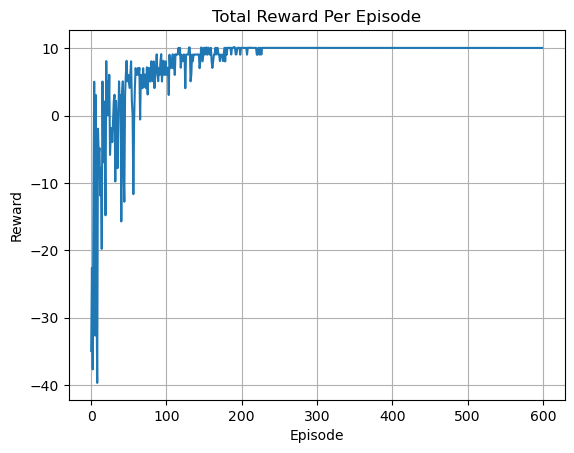

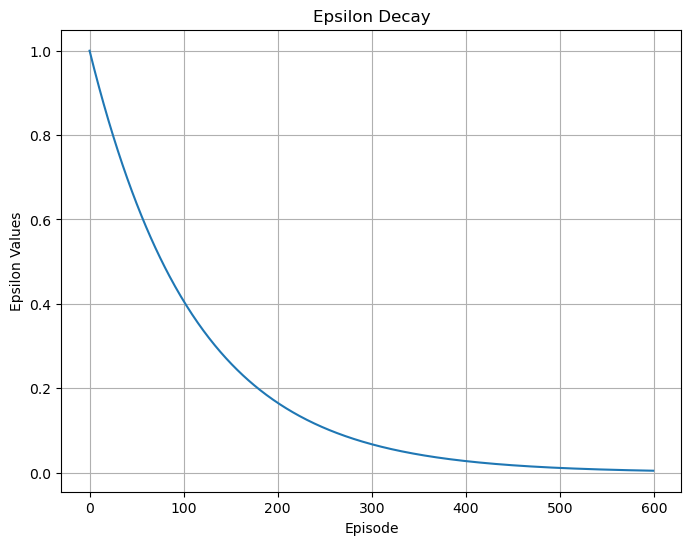

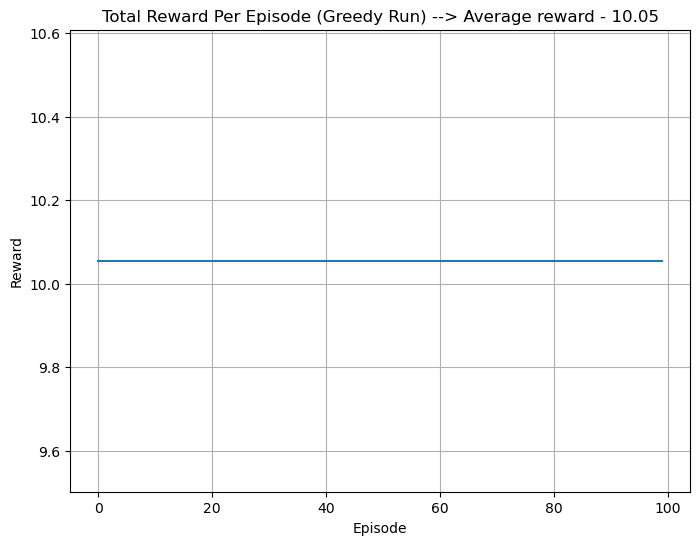

Average Reward For 100 Episodes (Evaluation) - 10.05


In [35]:
env = MyWorldEnv("human", 6)
n_actions = env.action_space.n
state, info = env.reset()
n_observations = len(state)
dqn = DQN(n_observations, n_actions, True)
dqn.train(600)
grid_per_reward = dqn.rewards
dqn.plot()
dqn.plotEpsilonVsEpisode()
dqn.test()

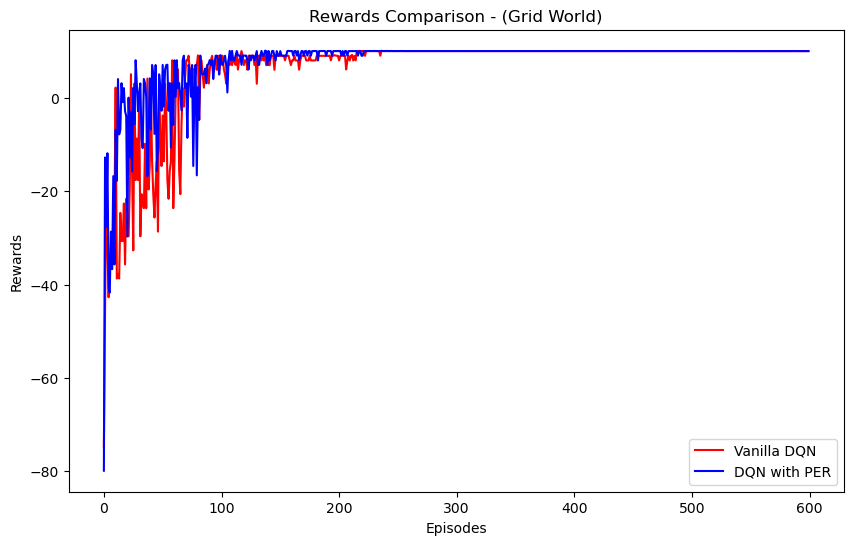

In [19]:

plt.figure(figsize=(10, 6)) 
plt.plot(grid_dqn_reward, color='red', label='Vanilla DQN')
plt.plot(grid_per_reward, color='blue', label='DQN with PER')
plt.title('Rewards Comparison - (Grid World)')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend()

## 2. CartPole - (Prioritized Experience Replay (PER))

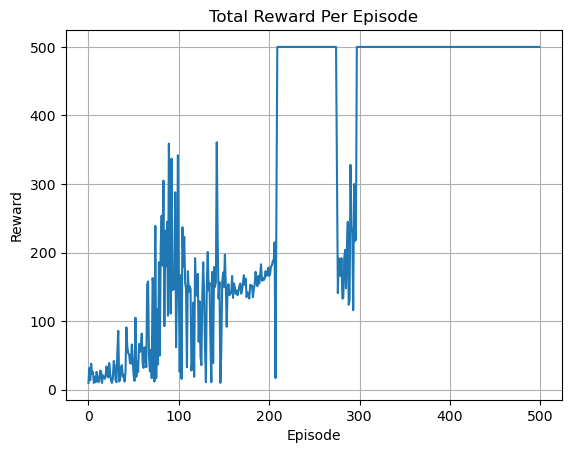

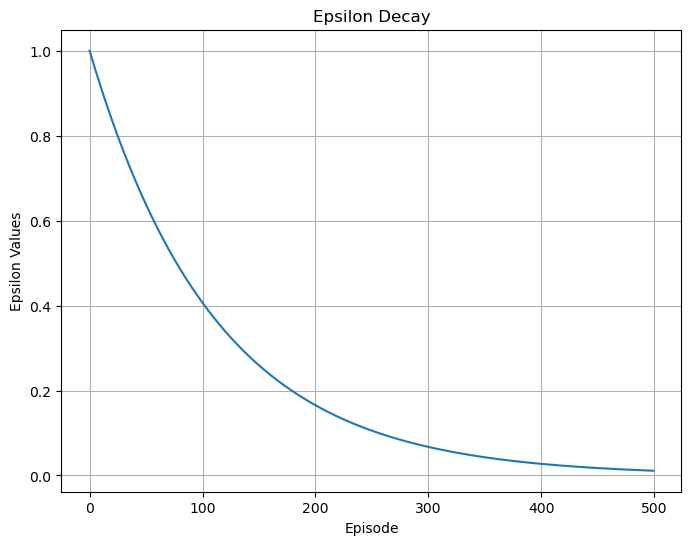

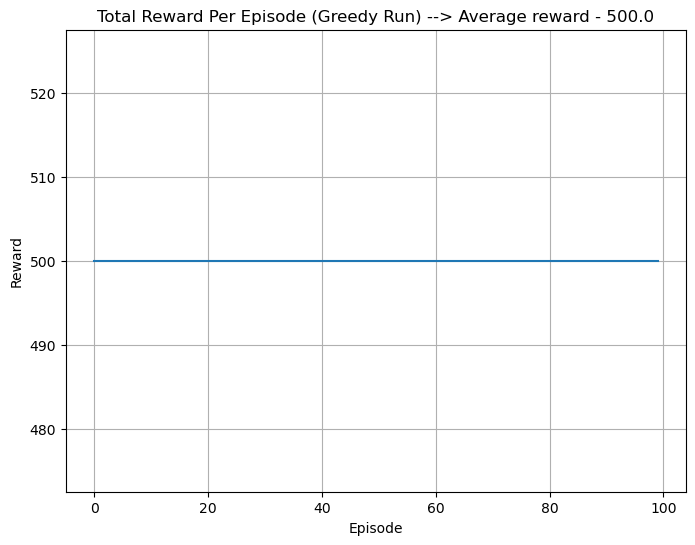

Average Reward For 100 Episodes (Evaluation) - 500.0


In [36]:
env = gym.make("CartPole-v1")
n_actions = env.action_space.n
state, info = env.reset()
n_observations = len(state)
dqn = DQN(n_observations, n_actions, True)
dqn.BATCH_SIZE = 12
dqn.train(500)
cartpole_per_reward = dqn.rewards
dqn.plot()
dqn.plotEpsilonVsEpisode()
dqn.test()

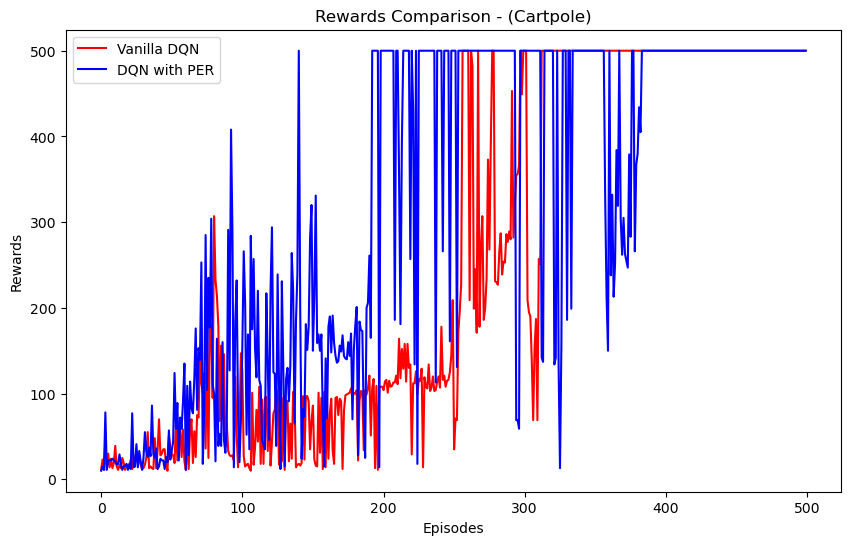

In [21]:
plt.figure(figsize=(10, 6)) 
plt.plot(cartpole_dqn_reward, color='red', label='Vanilla DQN')
plt.plot(cartpole_per_reward, color='blue', label='DQN with PER')
plt.title('Rewards Comparison - (Cartpole)')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend()

## 3. Mountaincar - (Prioritized Experience Replay (PER))

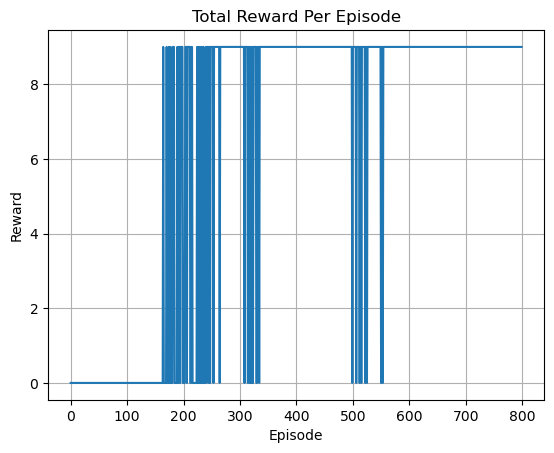

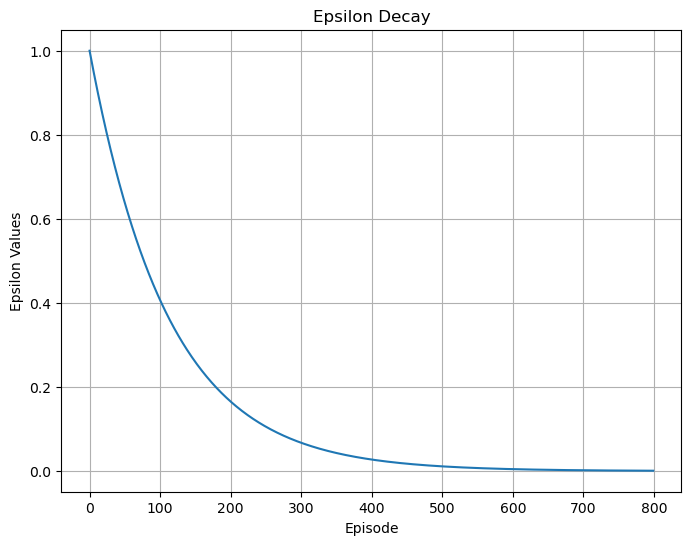

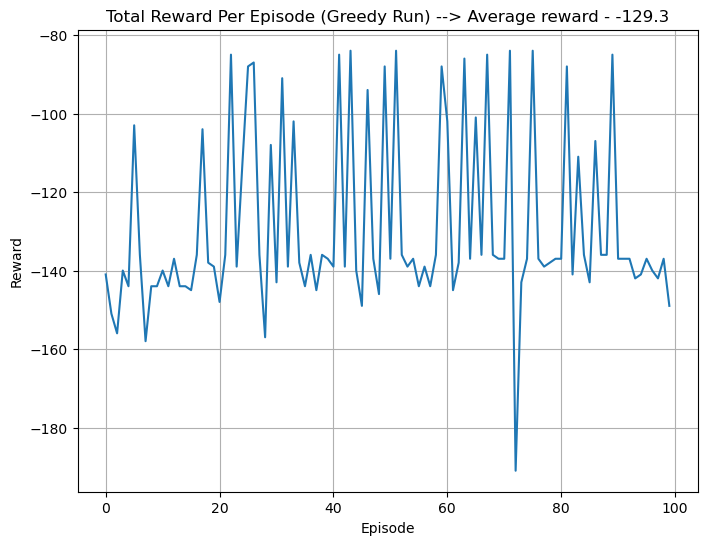

Average Reward For 100 Episodes (Evaluation) - -129.3


In [37]:
#=============================================================== MountainCar
env = gym.make("MountainCar-v0")
n_actions = env.action_space.n
state, info = env.reset()
n_observations = len(state)
dqn = DQN(n_observations, n_actions, True)
dqn.BATCH_SIZE = 24
dqn.env_name = "MountainCar-v0"
dqn.train(800)
dqn.E_DECAY = 0.005
car_per_reward = dqn.rewards
dqn.plot()
dqn.plotEpsilonVsEpisode()
dqn.test()

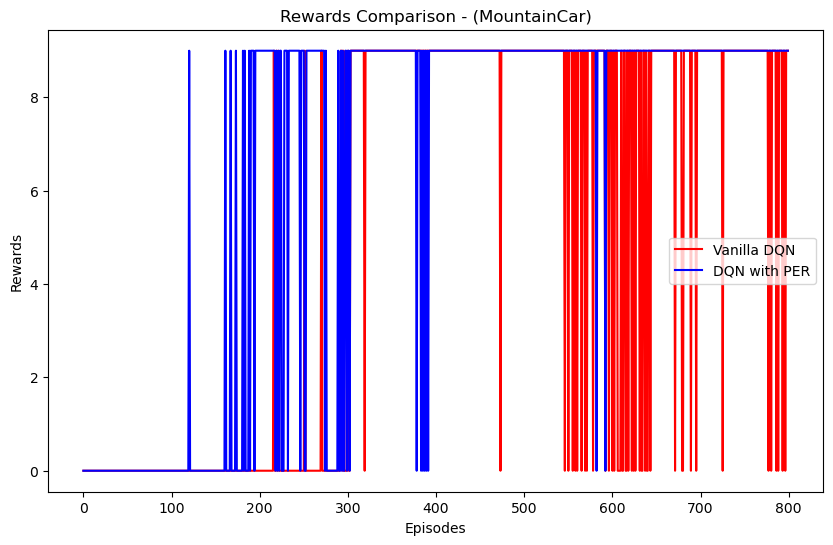

In [25]:
plt.figure(figsize=(10, 6)) 
plt.plot(car_dqn_reward, color='red', label='Vanilla DQN')
plt.plot(car_per_reward, color='blue', label='DQN with PER')
plt.title('Rewards Comparison - (MountainCar)')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend()

# Bonus Part
## RL Libraries ( Stable - baseline3)
### 1. GridWorld Environment

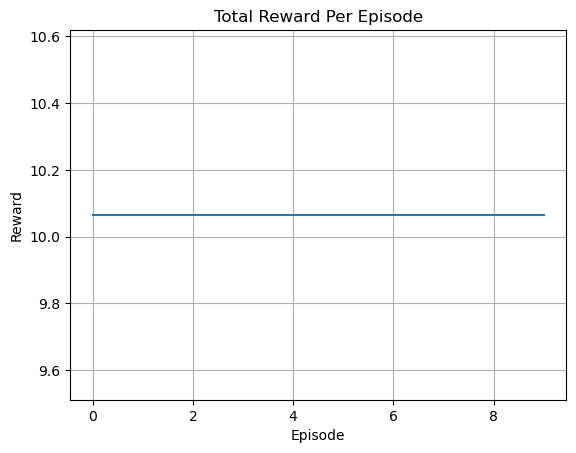

In [27]:
from stable_baselines3 import PPO,DQN

env = MyWorldEnv("human", 6)
state, info = env.reset()
model = DQN("MlpPolicy", env)
model.learn(total_timesteps=900000)
obs, info = env.reset()

r = 0
rg = []
for i in range(10):
    r = 0
    while True:
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)
        r += reward
        if terminated or truncated:
            obs, info = env.reset()
            break
    # print(r)
    rg.append(r)

plt.plot(rg)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Total Reward Per Episode')
plt.grid(True)
plt.show()

### 2. CartPole 

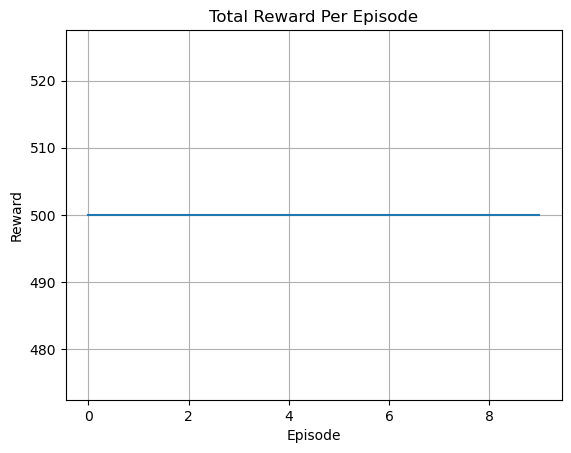

In [40]:
from stable_baselines3 import PPO,DQN
env = gym.make("CartPole-v1")
model = DQN("MlpPolicy", env)
model.learn(total_timesteps=2500000, log_interval=4)
obs, info = env.reset()
r = 0
rg = []
for i in range(10):
    r = 0
    while True:
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)
        r += reward
        if terminated or truncated:
            obs, info = env.reset()
            break
    # print(r)
    rg.append(r)

plt.plot(rg)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Total Reward Per Episode')
plt.grid(True)
plt.show()

### 3. MountainCar

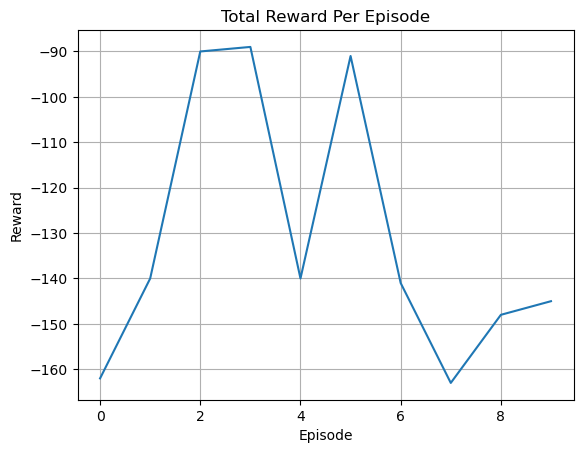

In [31]:
env = gym.make("MountainCar-v0")
model = DQN("MlpPolicy", env)
model.learn(total_timesteps=4000000, log_interval=4)
obs, info = env.reset()
r = 0
rg = []
for i in range(10):
    r = 0
    while True:
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)
        r += reward
        if terminated or truncated:
            obs, info = env.reset()
            break
    # print(r)
    rg.append(r)

plt.plot(rg)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Total Reward Per Episode')
plt.grid(True)
plt.show()

# Bonus Part
## Image Base Environment - (Atari Breakout)

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA GPU.")
    
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Apple Silicon GPU).")
    
else:
    device = torch.device("cpu")
    print("Using CPU.")

print(device)

Using MPS (Apple Silicon GPU).
mps


In [12]:
import gymnasium as gym
import torch, random
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import torchvision.transforms as t
import numpy as np
import matplotlib.pyplot as plt
import cv2

class Net(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_observations, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, n_actions)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)
    
class CNN(nn.Module):
    def __init__(self, h, w, n_actions):
        super(CNN, self).__init__()
        self.conv2d = nn.Conv2d(4, 64, kernel_size=8, stride=4)
        self.conv2d2 = nn.Conv2d(64, 64, kernel_size=4, stride=2)
        self.conv2d3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc1_size = 64*22*16
        self.fc1 = nn.Linear(self.fc1_size, 512)
        self.fc2 = nn.Linear(512, n_actions)

    def forward(self, x):
        x = F.relu(self.conv2d(x))
        x = F.relu(self.conv2d2(x))
        x = F.relu(self.conv2d3(x))
        if len(x.shape) > 3:
            x = x.view(x.size(0), -1)
        else: 
            x = x.flatten()
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
class DQN():
    def __init__(self, n_observations, n_actions, input_type):
        self.replay_memory = deque([], maxlen=10000)
        if input_type != "image":
            self.policy_net = Net(n_observations, n_actions)
            self.target_net = Net(n_observations, n_actions)
        else:
            h , w = n_observations
            self.policy_net = CNN(h, w, n_actions).to(device=device)
            self.target_net = CNN(h, w, n_actions).to(device=device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        
        self.BATCH_SIZE = 128

        self.GAMMA = 0.99
        self.TAU = 0.005
        self.LR = 1e-4
        self.E_DECAY = 0.001
        self.epsilon = 1
        self.update_freq = 5
        self.optimizer = optim.AdamW(self.policy_net.parameters(), lr=self.LR, amsgrad=True)
        
        self.rewards = []
        
    def learn(self):
        if len(self.replay_memory) < self.BATCH_SIZE:
            return
        batch = random.sample(self.replay_memory, self.BATCH_SIZE)
        state_batch, action_batch, next_state_batch, reward_batch = zip(*[(item[0], item[1], item[2], item[3]) for item in batch])
        state_batch = torch.cat(state_batch).to(device=device)
        action_batch = torch.cat(action_batch).to(device=device)
        # next_state_batch = torch.cat(next_state_batch)
        reward_batch = torch.cat(reward_batch).to(device=device)
        
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)
        
        ##################################
        non_terminate_state_position = torch.tensor([s is not None for s in next_state_batch], device=device)
        non_terminate_state = torch.cat([s for s in next_state_batch if s is not None]).to(device=device)
        next_state_values = torch.zeros(self.BATCH_SIZE, device=device)
        next_state_values[non_terminate_state_position] = self.target_net(non_terminate_state).max(1).values
        ####################################
        # target_state_action_values = torch.cat([self.target_net(ns).max(1).values if ns != None else torch.zeros(1) for ns in next_state_batch])
        
        expected_state_action_values = (next_state_values * self.GAMMA) + reward_batch
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
        self.optimizer.step()
        
        
    def train(self, n_episodes):
        total_reward = 0
        for e in range(n_episodes):
            print("-----------------------------------> n_episode : "+str(e)+" , "+str(self.epsilon)+" , Reward : "+str(total_reward))
            state, info = env.reset()
            # state = cv2.cvtColor(state, cv2.COLOR_BGR2GRAY)
            # state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            # state = torch.from_numpy(state).unsqueeze(0).float().to(device=device)
            grey_state = []
            for frame in state:
                grey_state.append(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY))
            state = grey_state
            state = np.array(state)
            state = torch.tensor(state).float().to(device=device) 
            total_reward = 0
            self.update_freq -= 1
            while True:
                s = np.random.uniform(0,1)
                if s < self.epsilon:
                    action = torch.tensor([[env.action_space.sample()]],device=device, dtype=torch.long)
                else:
                    action = self.policy_net(state).max(0).indices.view(1, 1)
                observation, reward, terminated, truncated, _ = env.step(action.item())
                # if reward > 0:
                # print(reward)
                # observation = cv2.cvtColor(observation, cv2.COLOR_BGR2GRAY)
                done = terminated or truncated
                total_reward += reward
                reward = torch.tensor([reward])
                if terminated:
                    next_state = None
                else:
                    # next_state = torch.tensor(observation, dtype=torch.float32).unsqueeze(0)
                    # next_state = torch.from_numpy(observation).unsqueeze(0).float().to(device=device)
                    grey_state = []
                    for frame in observation:
                        grey_state.append(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY))
                    next_state = grey_state
                    next_state = np.array(next_state)
                    next_state = torch.tensor(next_state).float().to(device=device)
                    next_state_squeezed = next_state.unsqueeze(0)
                self.replay_memory.append([state.unsqueeze(0), action, next_state_squeezed, reward])
                self.learn()
                state = next_state
                
                target_net_state_dict = self.target_net.state_dict()
                policy_net_state_dict = self.policy_net.state_dict()
                for key in policy_net_state_dict:
                    target_net_state_dict[key] = policy_net_state_dict[key]*self.TAU + target_net_state_dict[key]*(1-self.TAU)
                self.target_net.load_state_dict(target_net_state_dict)
                if terminated or truncated:
                    break
                
            self.epsilon = np.exp(-1*self.E_DECAY*e)
            self.rewards.append(total_reward)
            
    def test(self):
        for i in range(10):
            state, info = env.reset()
            while True:
                state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
                action = self.policy_net(state).max(1).indices.view(1, 1)
                observation, reward, terminated, truncated, _ = env.step(action.item())
                env.render()
                state = observation
                if terminated or truncated:
                    break
    
if __name__ == "__main__":
    #=============================================================== Atari
    env = gym.make("ALE/Breakout-v5", render_mode="human")
    env.metadata['render_fps'] = 60
    env = gym.wrappers.FrameStack(env, 4)
    n_actions = env.action_space.n
    state, info = env.reset()
    print(state.shape)

    # state = cv2.cvtColor(state, cv2.COLOR_BGR2GRAY) 
    n_observations = state.shape[0]
    dqn = DQN((n_observations,n_observations), n_actions, "image")
    dqn.train(1)
    env.close()

(4, 210, 160, 3)
-----------------------------------> n_episode : 0 , 1 , Reward : 0
